### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer
Chapter 7    

In [82]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [83]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.

dataset_path = 'intermediate_datafiles/'
export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
    dataset_bf = pd.read_csv(dataset_path + 'chapter4_result_bf.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = dataset.index.to_datetime()
dataset_bf.index = dataset_bf.index.to_datetime()

C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


In [84]:
bench = dataset[list(dataset_bf)][dataset[list(dataset_bf)]['labelBenchPress'] == 1]

In [85]:
dataset = pd.concat([bench, dataset_bf])

In [86]:
del dataset['participant']
del dataset['set']
del dataset['labelBenchPress']
del dataset['labelDeadlift']
del dataset['labelOHP']
del dataset['labelSquat']
del dataset['labelRow']
del dataset['labelRest']

In [87]:
dataset['category'] = dataset['category'].apply(lambda x: 'good' if x == 'heavy' or x == 'medium' else x)

In [101]:
dataset.dropna(inplace=True)

In [102]:
X = dataset.drop('category', axis=1)
y = dataset['category']

In [103]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [104]:
# Select subsets of the features that we will consider:

basic_features = ['acc_x','acc_y','acc_z', 'gyr_x','gyr_y','gyr_z', 'acc_r', 'gyr_r']
time_features = [name for name in dataset.columns if '_temp_' in name]
freq_features = [name for name in dataset.columns if (('_freq' in name) or ('_pse' in name))]
print '#basic features: ', len(basic_features)
print '#time features: ', len(time_features)
print '#frequency features: ', len(freq_features)
features_after_chapter_3 = list(set().union(basic_features))
features_after_chapter_4 = list(set().union(basic_features, time_features, freq_features))

#basic features:  8
#time features:  16
#frequency features:  58


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
[0.89316770186335404, 0.97391304347826091, 0.98881987577639752, 0.99627329192546588, 0.99751552795031051, 0.99875776397515525, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99875776397515525, 0.99378881987577639, 0.99627329192546588]
['gyr_r_freq_0.0_Hz_ws_50', 'acc_z_temp_mean_ws_5', 'acc_y_temp_std_ws_5', 'acc_x', 'acc_r_freq_0.5_Hz_ws_50', 'gyr_r_pse', 'acc_r_freq_0.4_Hz_ws_50', 'gyr_r_freq_2.0_Hz_ws_50', 'acc_r_freq_1.2_Hz_ws_50', 'acc

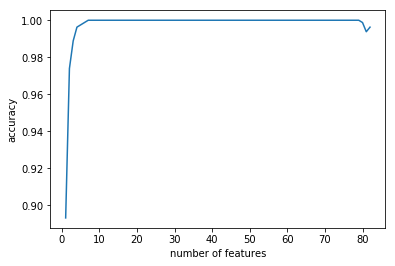

In [105]:
#First, let us consider the performance over a selection of features:

fs = FeatureSelectionClassification()

features, ordered_features, ordered_scores = fs.forward_selection(82, train_X[features_after_chapter_4], train_y)
print ordered_scores
print ordered_features

plot.plot(range(1, 83), ordered_scores)
plot.xlabel('number of features')
plot.ylabel('accuracy')
plot.show()

In [108]:
selected_features = ordered_features[:10]

In [110]:
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

In [ ]:
possible_feature_sets = [basic_features, features_after_chapter_3, features_after_chapter_4, selected_features]
feature_names = ['initial set', 'Chapter 3', 'Chapter 4', 'Selected features']
repeats = 5

scores_over_all_algs = []

for i in range(0, len(possible_feature_sets)):
    selected_train_X = train_X[possible_feature_sets[i]]
    selected_test_X = test_X[possible_feature_sets[i]]

    # First we run our non deterministic classifiers a number of times to average their score.

    performance_tr_nn = 0
    performance_tr_rf = 0
    performance_tr_svm = 0
    performance_te_nn = 0
    performance_te_rf = 0
    performance_te_svm = 0

    for repeat in range(0, repeats):
        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.feedforward_neural_network(selected_train_X, train_y, selected_test_X, gridsearch=True)
        performance_tr_nn += eval.accuracy(train_y, class_train_y)
        performance_te_nn += eval.accuracy(test_y, class_test_y)

        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(selected_train_X, train_y, selected_test_X, gridsearch=True)
        performance_tr_rf += eval.accuracy(train_y, class_train_y)
        performance_te_rf += eval.accuracy(test_y, class_test_y)

        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.support_vector_machine_with_kernel(selected_train_X, train_y, selected_test_X, gridsearch=True)
        performance_tr_svm += eval.accuracy(train_y, class_train_y)
        performance_te_svm += eval.accuracy(test_y, class_test_y)


    overall_performance_tr_nn = performance_tr_nn/repeats
    overall_performance_te_nn = performance_te_nn/repeats
    overall_performance_tr_rf = performance_tr_rf/repeats
    overall_performance_te_rf = performance_te_rf/repeats
    overall_performance_tr_svm = performance_tr_svm/repeats
    overall_performance_te_svm = performance_te_svm/repeats

    # And we run our deterministic classifiers:


    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.k_nearest_neighbor(selected_train_X, train_y, selected_test_X, gridsearch=True)
    performance_tr_knn = eval.accuracy(train_y, class_train_y)
    performance_te_knn = eval.accuracy(test_y, class_test_y)

    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.decision_tree(selected_train_X, train_y, selected_test_X, gridsearch=True)
    performance_tr_dt = eval.accuracy(train_y, class_train_y)
    performance_te_dt = eval.accuracy(test_y, class_test_y)

    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.naive_bayes(selected_train_X, train_y, selected_test_X)
    performance_tr_nb = eval.accuracy(train_y, class_train_y)
    performance_te_nb = eval.accuracy(test_y, class_test_y)

    scores_with_sd = util.print_table_row_performances(feature_names[i], len(selected_train_X.index), len(selected_test_X.index), [
                                                                                                (overall_performance_tr_nn, overall_performance_te_nn),
                                                                                                (overall_performance_tr_rf, overall_performance_te_rf),
                                                                                                (overall_performance_tr_svm, overall_performance_te_svm),
                                                                                                (performance_tr_knn, performance_te_knn),
                                                                                                (performance_tr_dt, performance_te_dt),
                                                                                                (performance_tr_nb, performance_te_nb)])
    scores_over_all_algs.append(scores_with_sd)

initial set  &  0.8484 \emph{( 0.8232 - 0.8737 )}  &  0.8493 \emph{( 0.8108 - 0.8878 )}  &  0.9816 \emph{( 0.9721 - 0.9911 )}  &  0.8962 \emph{( 0.8634 - 0.9291 )}  &  0.8509 \emph{( 0.8258 - 0.8760 )}  &  0.8464 \emph{( 0.8076 - 0.8852 )}  &  0.8907 \emph{( 0.8687 - 0.9127 )}  &  0.8290 \emph{( 0.7884 - 0.8695 )}  &  0.9776 \emph{( 0.9672 - 0.9881 )}  &  0.8725 \emph{( 0.8365 - 0.9084 )}  &  0.7665 \emph{( 0.7366 - 0.7963 )}  &  0.7768 \emph{( 0.7320 - 0.8216 )} \\\hline
Chapter 3  &  0.8484 \emph{( 0.8232 - 0.8737 )}  &  0.8493 \emph{( 0.8108 - 0.8878 )}  &  0.9826 \emph{( 0.9734 - 0.9918 )}  &  0.9026 \emph{( 0.8707 - 0.9345 )}  &  0.8509 \emph{( 0.8258 - 0.8760 )}  &  0.8464 \emph{( 0.8076 - 0.8852 )}  &  0.8907 \emph{( 0.8687 - 0.9127 )}  &  0.8290 \emph{( 0.7884 - 0.8695 )}  &  0.9764 \emph{( 0.9657 - 0.9871 )}  &  0.8754 \emph{( 0.8398 - 0.9109 )}  &  0.7665 \emph{( 0.7366 - 0.7963 )}  &  0.7768 \emph{( 0.7320 - 0.8216 )} \\\hline


C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Chapter 4  &  0.8877 \emph{( 0.8654 - 0.9100 )}  &  0.8551 \emph{( 0.8172 - 0.8930 )}  &  0.9993 \emph{( 0.9973 - 1.0012 )}  &  0.9559 \emph{( 0.9338 - 0.9780 )}  &  1.0000 \emph{( 1.0000 - 1.0000 )}  &  0.8870 \emph{( 0.8529 - 0.9211 )}  &  0.9553 \emph{( 0.9407 - 0.9698 )}  &  0.9043 \emph{( 0.8727 - 0.9360 )}  &  0.9963 \emph{( 0.9920 - 1.0006 )}  &  0.9536 \emph{( 0.9310 - 0.9763 )}  &  0.9019 \emph{( 0.8809 - 0.9228 )}  &  0.9333 \emph{( 0.9065 - 0.9602 )} \\\hline
